In [1]:
from utils import *
from modeling import *
from plotting import *

%load_ext autoreload
%autoreload 2

## Measurement

mu: 460.20 , std: 4.02 , ZP: 27.30 , pix_scale: 2.50


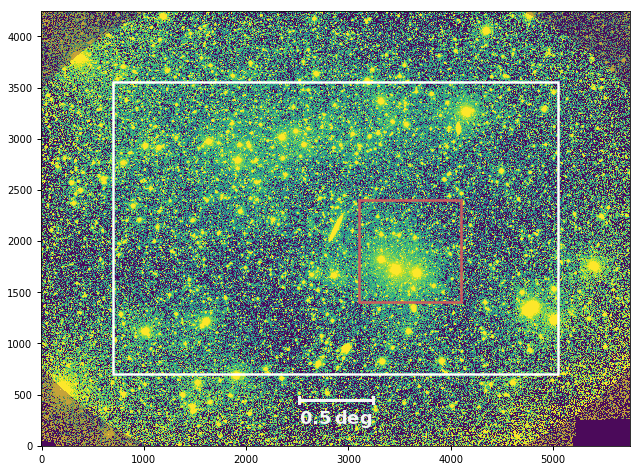

In [2]:
############################################
# Read 
############################################
use_PS1_DR2 = True
R_scale = 10
obj_name = 'NGC5907-G'
band = 'G'

with fits.open("./data/coadd_Sloan%s_NGC_5907.fits"%band) as hdul:
        data = hdul[0].data
        header = hdul[0].header
        wcs_data = wcs.WCS(header)

# Runned from create_photometric_light_APASS 
seg_map = fits.getdata("./SE_APASS/coadd_Sloan%s_NGC_5907_seg.fits"%band)
seg_map_dilation = seg_map.copy()
for i in range(5):
    seg_map_dilation= morphology.dilation(seg_map_dilation)

weight_edge = fits.getdata("./SE_APASS/weight_NGC5907.fits")
SE_cat_full = Table.read("./SE_APASS/coadd_Sloan%s_NGC_5907.cat"%band,
                         format="ascii.sextractor")

mu = np.float(header["BACKVAL"])
ZP, pix_scale = np.float(header["ZP"]), np.float(header["PIXSCALE"])

data_clip = sigma_clip(data[seg_map_dilation==0&(weight_edge>0.5)], sigma=3, maxiters=10)
std = np.std(data_clip) 

print("mu: %.2f , std: %.2f , ZP: %.2f , pix_scale: %.2f" %(mu, std, ZP, pix_scale))

flux = SE_cat_full["FLUX_AUTO"]
SE_cat_full["MAG_AUTO"] = -2.5 * np.ma.log10(flux).filled(flux[flux>0].min()) + ZP

############################################
# Crop
############################################
# patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (800, 800, 1800, 1800)
# patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = [1800, 2400, 2800, 3400]
patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (3100, 1400, 4100, 2400)

catalog_bounds = (patch_Xmin-100, patch_Ymin-100, patch_Xmax+100, patch_Ymax+100)
image_size = patch_Xmax - patch_Xmin

image_bounds = [[patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax]]
    
field_bounds = [700, 700, data.shape[1]-700, data.shape[0]-700]
patch, seg_patch = crop_image(data, field_bounds, seg_map,
                              weight_map=weight_edge, sub_bounds=image_bounds, draw=True)

In [155]:
"{0:016b}".format(0xFFFFFFFF & interpret_bit_flags(114808))[-7]

'1'

In [161]:
# Cross-match with PAN-STARRS DR2
tab_target, tab_target_full, catalog_star \
            = cross_match_PS1_DR2(wcs_data, SE_cat_full, image_bounds, band='g')
tab_target[:10]

Search 0.491 deg around:
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (228.07004081, 56.16995906)>
Matched stars with PANSTARRS DR2 gMeanPSFMag:  7.754 ~ 22.432
Matched bright stars with PANSTARRS DR2 gMeanPSFMag:  7.754 ~ 14.994


NUMBER,FLUX_AUTO,X_IMAGE,Y_IMAGE,X_WORLD,Y_WORLD,FWHM_IMAGE,MAG_AUTO,ID_PS,raMean,decMean,raMeanErr,decMeanErr,nDetections,ng,nr,gMeanPSFMag,gMeanPSFMagErr,gFlags,rMeanPSFMag,rMeanPSFMagErr,rFlags,X_IMAGE_PS,Y_IMAGE_PS
,ct,pix,pix,deg,deg,pix,,,deg,deg,,,,,,,,,,,,pix,pix
int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,int64,float64,float64,int64,float64,float64
19063,6369070.0,3466.0796,1721.5258,228.24070208,56.046451325,7.07,10.085963936184577,2,228.24078111,56.04650933,0.00100,0.00100,9,3,2,7.7540,0.022028999403119087,32824,6.6749,1.2999999853491317e-05,16,3465.0151,1720.6087
19617,5273856.0,3670.7646,1693.4302,227.98675202,56.025171198,6.63,10.290833322809263,5,227.98666026,56.02563482,0.00100,0.00100,5,2,1,8.3534,0.47813600301742554,24,7.7729,0.0010000000474974513,16,3669.8289,1693.0989
18466,3842712.0,3321.3972,1824.0864,228.41955121,56.118606551,5.57,10.63455939990937,6,228.42024166,56.11867767,0.00100,0.00100,17,2,3,9.3757,0.15221300721168518,114744,8.3525,0.07899399846792221,114744,3319.8421,1823.1844
20822,1571271.0,3834.8767,1565.9124,227.78560648,55.934841547,3.93,11.605526253702687,7,227.7856392,55.93483781,0.09711,0.09711,10,1,1,10.4674,0.0010000000474974513,24,10.4994,0.0010000000474974513,16,3833.8505,1564.9065
16683,1361611.0,3652.0815,2038.4492,228.00391739,56.264914082,4.03,11.761021363187076,13,228.00385223,56.26501746,0.00100,0.00100,12,4,2,11.6351,0.05276999995112419,114744,12.5173,-999.0,114744,3651.1316,2037.5988
21048,1433815.0,3634.0322,1540.8929,228.03497774,55.919617353,3.82,11.704921192650467,14,228.03481766,55.91958798,-999.00000,-999.00000,17,3,2,11.6498,0.03462500125169754,24,10.4833,0.0,24,3633.1619,1539.8524
15029,882265.4,3287.1345,2242.3711,228.45831901,56.409253377,3.53,12.232155872031996,15,228.45849624,56.40916312,0.06486,0.03476,73,11,15,11.8210,-999.0,245860,11.5740,-999.0,114788,3285.9944,2241.24
16430,1538869.0,3322.2563,2066.9353,228.41602509,56.287237808,4.17,11.62814986381991,18,228.41647455,56.28701781,0.25878,0.25878,14,4,2,12.0118,0.053507000207901,16777240,11.0425,0.06644800305366516,24,3320.8996,2065.6155


In [ ]:
# Cross-match with PAN-STARRS DR2
tab_target, tab_target_full, catalog_star \
            = cross_match_PS1_DR2(wcs_data, SE_cat_full, image_bounds, band='g')
tab_target[:10]

Search 0.491 deg around:
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (228.07004081, 56.16995906)>


In [4]:
# Alternatively, uncleaned cross-match (inc. duibious items)
catalog_star

ID_PS,objID,raMean,decMean,nDetections,ng,nr,gMeanPSFMag,rMeanPSFMag,X_IMAGE_PS,Y_IMAGE_PS
,,deg,deg,,,,,,pix,pix
int64,int64,float64,float64,int64,int64,int64,float64,float64,float64,float64
1,175252282412046577,228.24119,56.046513,4,0,2,7.5520,7.6120,3465.6862,1721.6105
2,175252282408376305,228.24078111,56.04650933,9,3,2,7.7540,6.6749,3466.0151,1721.6087
3,175232279868030897,227.987235,56.02515,14,1,1,7.8390,7.9680,3670.3764,1693.3941
4,175342284197932877,228.41972833,56.11868701,3,1,1,7.9324,8.6055,3321.2541,1824.2012
5,175232279866781291,227.98666026,56.02563482,5,2,1,8.3534,7.7729,3670.8289,1694.0989
6,175342284201873140,228.42024166,56.11867767,17,2,3,9.3757,8.3525,3320.8421,1824.1844
7,175122277855932567,227.7856392,55.93483781,10,1,1,10.4674,10.4994,3834.8505,1565.9065
8,175542284160835458,228.41594396,56.28717186,52,8,10,10.6110,10.2440,3322.3219,2066.8408


In [5]:
# Alternatively, Crossmatch with star catalog by Vizier
############################################
if not use_PS1_DR2:
    tab_target, tab_target_full, catalog_star = cross_match(wcs_data, SE_cat_full,
                                                            field_bounds, mag_thre=15, mag_name='gmag')
    tab_target = crop_catalog(tab_target, image_bounds[0],
                              keys=("X_IMAGE", "Y_IMAGE"), sortby='gmag_PS')
    print(tab_target[:10])

Search 1.806 deg around:
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (228.97437372, 56.32951389)>
Pan-STARRS rmag:  6.675 ~ 22.998
Pan-STARRS gmag:  7.754 ~ 28.284
Matched stars with Pan-STARRS gmag:  7.754 ~ 22.508
Matched bright stars with Pan-STARRS gmag:  7.754 ~ 14.997



Average Color Term [SE-catalog] = -0.12557


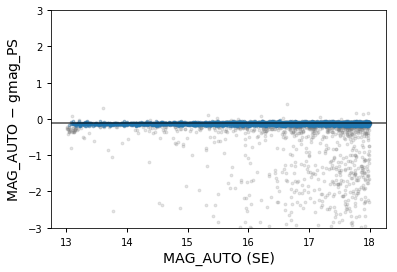

In [6]:
# Calculate color correction of PANSTAR and DF
if use_PS1_DR2:
    mag_name = 'gMeanPSFMag'
    mag_name_cat = 'gMeanPSFMag'
else:
    mag_name = 'gmag'
    mag_name_cat = 'gmag_PS'


CT = calculate_color_term(tab_target_full, mag_name=mag_name_cat)
catalog_star["MAG_AUTO"] = catalog_star[mag_name] + CT
tab_target["MAG_AUTO_corr"] = tab_target[mag_name_cat] + CT

In [5]:
# Save matched table and catalog 
tab_target_name = './Measure/%s-catalog_match_X%sY%s.txt'%(obj_name, patch_Xmin, patch_Ymin)
tab_target.write(tab_target_name, overwrite=True, format='ascii')

catalog_star_name = './Measure/%s-catalog_PS_X%sY%s.txt'%(obj_name, patch_Xmin, patch_Ymin)
catalog_star.write(catalog_star_name, overwrite=True, format='ascii')


Fit 3-order empirical relation of aperture radii for catalog stars based on SE (X2.5)


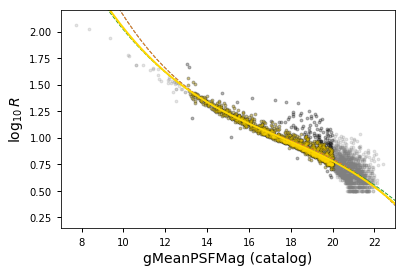


Make segmentation map based on catalog PS gMeanPSFMag: 6788 stars


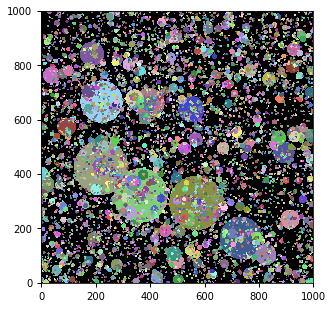

In [29]:
# Make segmentation map from catalog based on SE
estimate_radius = fit_empirical_aperture(tab_target_full, seg_map, mag_name=mag_name_cat,
                                         mag_range=[13,20], K=2.5, degree=3, draw=True)

catalog_bound = (patch_Xmin-100, patch_Ymin-100, patch_Xmax+100, patch_Ymax+100)
catalog_star_patch = crop_catalog(catalog_star, catalog_bound, sortby=mag_name,
                                          keys=("X_IMAGE"+'_PS', "Y_IMAGE"+'_PS'))

seg_map_cat = make_segm_from_catalog(catalog_star_patch, image_bounds[0], estimate_radius,
                                     mag_name=mag_name, cat_name='PS')

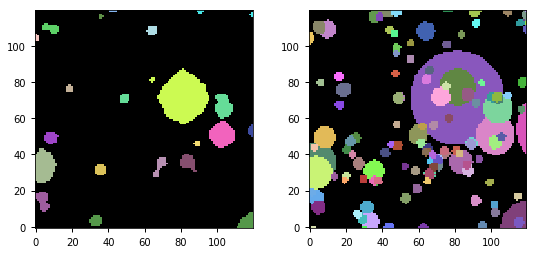

In [8]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(9,4))

ax1.imshow(seg_patch[607:727,262:382],vmin=1, cmap=make_rand_cmap(1000))

ax2.imshow(seg_map_cat[607:727,262:382],vmin=1, cmap=make_rand_cmap(12000))

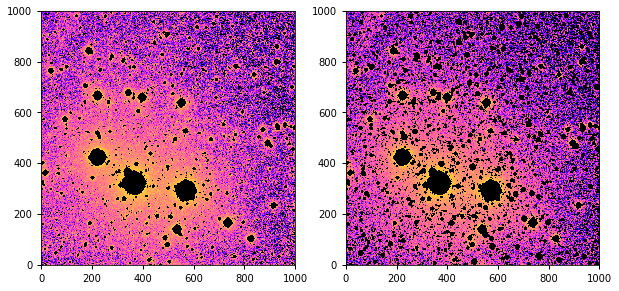

In [9]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
patch2=patch.copy()
patch2[seg_patch>0] = 0
ax1.imshow(patch2, vmin=mu-2, vmax=540, norm=norm1)
patch2=patch.copy()
patch2[(seg_map_cat>50)|(seg_patch>0)] = 0
ax2.imshow(patch2, vmin=mu-2, vmax=540, norm=norm1)

In [10]:
# Save segmentation map built from catalog
hdu_seg = fits.PrimaryHDU(seg_map_cat.astype(float))
hdu_seg.writeto("Seg_PS_X%dY%d.fits" %(patch_Xmin, patch_Ymin), overwrite=True)

In [40]:
# Measure average intensity (source+background) at R_scale
tab_res_Rnorm, res_thumb = measure_Rnorm_all(tab_target, image_bounds[0],
                                             wcs_data, data, seg_map, 
                                             r_scale=10, mag_thre=15, 
                                             obj_name=obj_name, mag_name='gmag_PS', 
                                             read=False, save=False, dir_name='./Measure')
tab_res_Rnorm[:10]

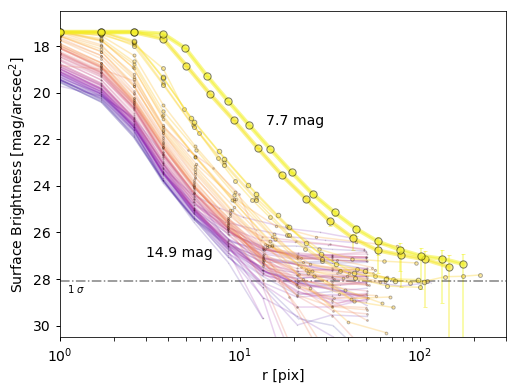

In [182]:
plot_bright_star_profile(tab_target, tab_res_Rnorm, res_thumb, bkg_sky=mu, std_sky=2.5)

In [58]:
# Measure average intensity (source+background) at R_scale
tab_res_Rnorm, res_thumb = measure_Rnorm_all(tab_target, image_bounds[0],
                                             wcs_data, data, seg_map, 
                                             r_scale=12, mag_thre=15, 
                                             obj_name=obj_name, mag_name=mag_name_cat, 
                                             read=False, save=False, dir_name='./Measure-PS')
tab_res_Rnorm[:10]

completed: 20/81
completed: 40/81
completed: 60/81
Errorenous measurement: # 19088
completed: 80/81


NUMBER,MAG_AUTO,MAG_AUTO_corr,gMeanPSFMag,X_IMAGE,Y_IMAGE,FWHM_IMAGE,X_IMAGE_PS,Y_IMAGE_PS,Imean,Imed,Istd,Isky,Iflag
,,,,pix,pix,pix,pix,pix,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
19063,10.085963936184577,7.6331,7.7540,3466.0796,1721.5258,7.07,3466.0151,1721.6087,1624.1267667051095,1677.9145153164727,160.1695297703109,466.6630124965428,0.0
19617,10.290833322809263,8.2325,8.3534,3670.7646,1693.4302,6.63,3670.8289,1694.0989,1251.7240322395473,1256.1263020332547,117.64350797010621,465.5809074302278,0.0
18466,10.63455939990937,9.2549,9.3757,3321.3972,1824.0864,5.57,3320.8421,1824.1844,922.3059042783748,914.7576312463036,75.04187823044396,464.5785602056093,0.0
16430,11.62814986381991,10.4901,10.6110,3322.2563,2066.9353,4.17,3322.3219,2066.8408,534.8079071242926,535.2837027053663,11.616072899038642,462.59257069842147,0.0
20822,11.605526253702687,10.4901,10.6110,3834.8767,1565.9124,3.93,3834.5348,1565.6548,527.8020679216814,526.4156161814869,6.614787389121824,462.68148842939206,0.0
16517,11.6171213010856,11.1481,11.2690,3497.1108,2059.6765,9.2,3497.8007,2060.6106,511.13418377881055,510.520096987329,9.13156236803425,462.494035253127,0.0
16683,11.761021363187076,11.5142,11.6351,3652.0815,2038.4492,4.03,3652.1316,2038.5988,517.6728926954762,514.5665214056881,10.10879151944741,462.2048912795654,0.0
15029,12.232155872031996,11.7001,11.8210,3287.1345,2242.3711,3.53,3286.9944,2242.24,486.2889518416654,485.06841254599146,4.427996522098282,461.0458553981353,0.0


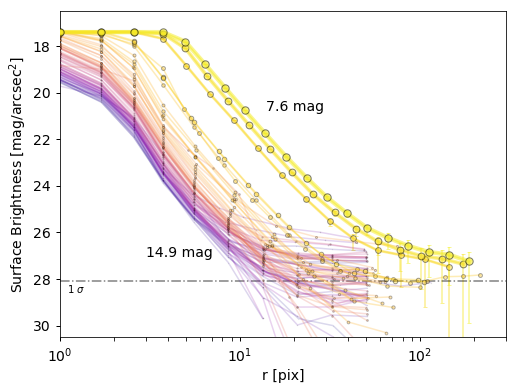

In [59]:
plot_bright_star_profile(tab_target, tab_res_Rnorm, res_thumb, bkg_sky=mu, std_sky=2.5)

## Example

NUMBER:  19617
X_c, Y_c:  (3670.7646, 1693.4302)
RA, DEC:  (227.98675202, 56.025171198)
x_min, x_max, y_min, y_max:  1427 1957 3405 3935
X_min, X_max, Y_min, Y_max:  3405.7646 3935.7646 1428.4302 1958.4302
[-0.3882 -0.0361] [0.0643 0.6687]


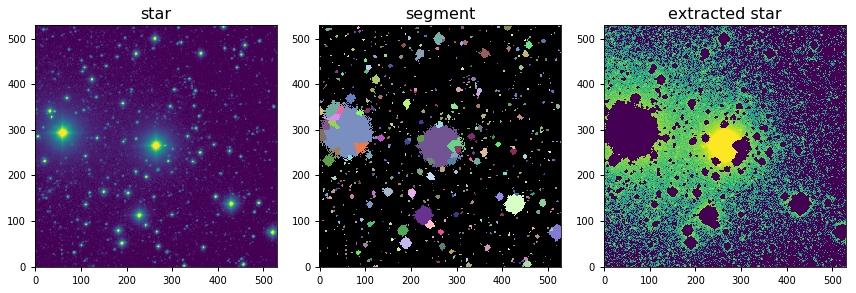

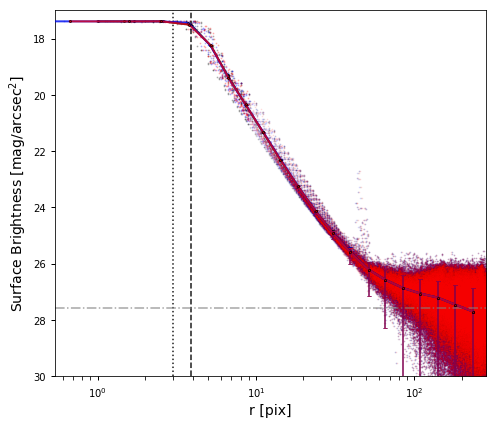

In [25]:
num = 19617
id = num-1
img_thumb, star_ma, star_bkg, cen_star = extract_star(id, SE_cat_full, wcs_data, data, seg_map=None,
                                                      n_win=40, sn_thre=3, display_bg=False, display=True, verbose=True)

obj = tab_target[tab_target['NUMBER']==num]

d1 = np.array([3670.3764, 1693.3941]) - np.array([3670.7646, 1693.4302])
d2 = np.array([3670.8289, 1694.0989]) - np.array([3670.7646, 1693.4302])
print(d1, d2)

plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_thumb, cen=cen_star, mask=star_ma, 
                                              ZP=ZP, sky_mean=mu, sky_std=std,
                                              xunit="pix", yunit="SB", color="k",
                                              scatter=True, markersize=2, errorbar=True, plot_line=True)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_thumb, cen=cen_star+d1, mask=star_ma, 
                                              ZP=ZP, sky_mean=mu, sky_std=std,
                                              xunit="pix", yunit="SB", color="b",
                                              scatter=True, markersize=2, errorbar=True, plot_line=False)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_thumb, cen=cen_star+d2, mask=star_ma, 
                                              ZP=ZP, sky_mean=mu, sky_std=std,
                                              xunit="pix", yunit="SB", color="r",
                                              scatter=True, markersize=2, errorbar=True, plot_line=False)

plt.xscale("log")
plt.tight_layout()
plt.savefig('Pics/profile#19617.png', dpi=150)

NUMBER:  12025
X_c, Y_c:  (3936.4358, 2605.7576)
RA, DEC:  (227.63464689, 56.655475736)
x_min, x_max, y_min, y_max:  2451 2759 3781 4089
X_min, X_max, Y_min, Y_max:  3782.4358 4090.4358 2451.7576 2759.7576


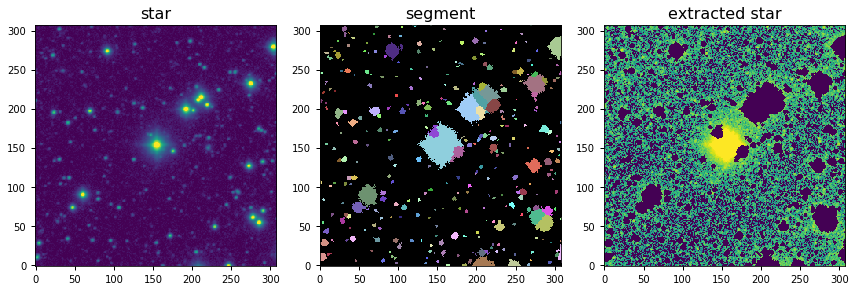

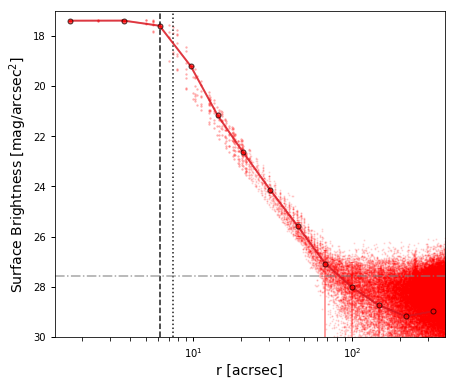

In [17]:
num = 12025
id = num-1
img_thumb, star_ma, star_bkg, cen_star = extract_star(id, SE_cat_full, wcs_data, data, seg_map=None,
                                                      n_win=40, sn_thre=3, display_bg=False, display=True, verbose=True)

obj = tab_target[tab_target['NUMBER']==num]

plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_thumb, cen=cen_star, mask=star_ma, 
                                              ZP=ZP, sky_mean=459, sky_std=std,
                                              xunit="arcsec", yunit="SB", color="r",
                                              scatter=True, errorbar=True, plot_line=True)

plt.xscale("log")

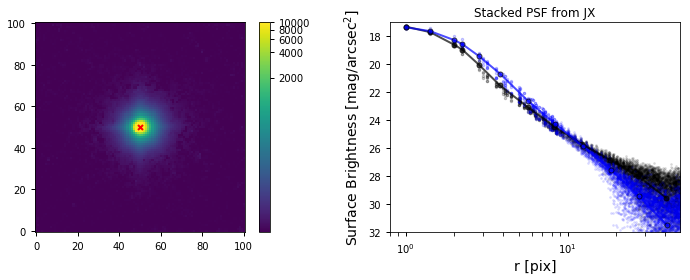

In [87]:
# Read median stack PSF
hdu = fits.open("./med_psf_JX.fits")[0]
hdu_p = fits.open("./median_psf_patch.fits")[0]
PSF_JX = hdu.data * 10 + mu
PSF_JX_p = hdu_p.data * 1e5 + mu

fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
im = ax1.imshow(PSF_JX_p, vmin=mu, vmax=10000, norm=norm1, aspect="equal", origin="lower", cmap="viridis")
ax1.plot(50,50,"rx",ms=5,mew=2)
colorbar(im)

ax2 = plt.subplot(122)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50),
                                             ZP=ZP, sky_mean=mu, sky_std=1, pixel_scale=pix_scale,
                                             xunit="pix", yunit="SB", color="k",
                                             scatter=True, core_undersample=True)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX_p, cen=(50,50),
                                             ZP=ZP, sky_mean=mu, sky_std=1, pixel_scale=pix_scale,
                                             xunit="pix", yunit="SB", color="b",
                                             scatter=True, core_undersample=True)
plt.ylim(32,17)
plt.title("Stacked PSF from JX")
plt.tight_layout()

NUMBER:  19088
X_c, Y_c:  (3441.7869, 1756.2905)
RA, DEC:  (228.27046103, 56.070766786)
x_min, x_max, y_min, y_max:  1655 1855 3341 3541
X_min, X_max, Y_min, Y_max:  3341.7869 3541.7869 1656.2905 1856.2905


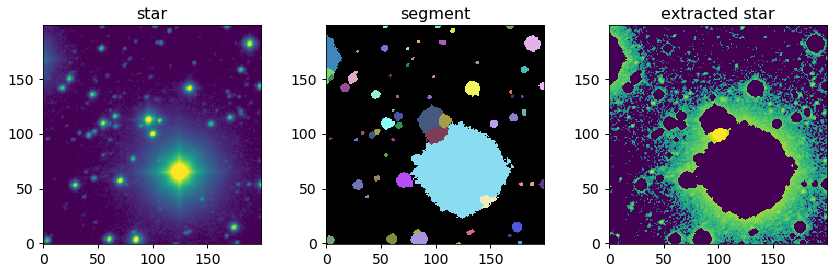

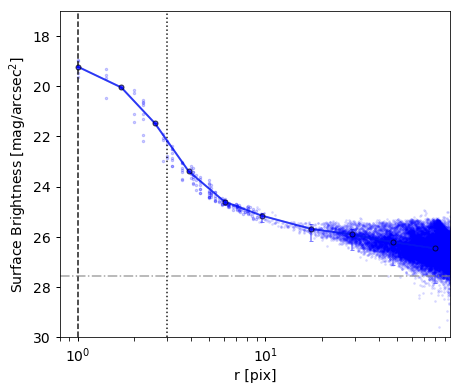

In [194]:
num = 19088
id = num-1
img_thumb, star_ma, star_bkg, cen_star = extract_star(id, SE_cat_full, wcs_data, data, seg_map=None,
                                                      n_win=40, sn_thre=3, display_bg=False, display=True, verbose=True)

obj = tab_SE_target[tab_SE_target['NUMBER']==num]

plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_thumb, cen=cen_star, mask=star_ma, 
                                              ZP=ZP, sky_mean=mu, sky_std=std,
                                              xunit="pix", yunit="SB", color="b",
                                              scatter=True, errorbar=True, plot_line=True)

plt.xscale("log")

In [11]:
import random
colour = [ "indianred", "steelblue", "seagreen", "gold", "lightcyan", "orchid", "orange", "gray", "brown" ]
random.seed(88)
rand_colours = [random.choice(colour) for i in range(len(tab_SE_target))]

psf = PSF_Model(params={"fwhm":2.28*pix_scale, "beta":10, 'theta_0':5},
                aureole_model='power', pixel_scale=2.5)

In [56]:
def plot_PSF(fit_res, res_thumb, tab_target, 
             r_core=12, pixel_scale=pix_scale, mag_name='rmag_PS',
             plot_stars=True, plot_stack=None, color='r', **kwargs):
    r = np.logspace(0.03,2.5,100)
    pmed, pmean, pcov = get_params_fit(fit_res1)    
    I_tot_A, I_tot_B, I_tot_C = plot_fit_res_SB(pmed, psf, r=r, **kwargs)
    mu_fit, std_fit = pmed[-2], pmed[-1]
    mu = 884
    
    z_mean_s, z_med_s = table_res_Rnorm['mean'],table_res_Rnorm['med'] 
    z_std_s, sky_mean_s = table_res_Rnorm['std'],table_res_Rnorm['sky']

    plt.figure(figsize=(10,8))
    for num, rmag, sky_m, c in zip(tab_target["NUMBER"], tab_target[mag_name], sky_mean_s, rand_colours):
        img, ma, cen = res_thumb[num]['image'], res_thumb[num]['mask'], res_thumb[num]['center']
        alpha = min(0.1*(16-rmag), 0.7) 
        errorbar = True if rmag<10 else False
        r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                                      ZP=ZP, sky_mean=mu, sky_std=std_fit, dr=1.5,
                                                      xunit="pix", yunit="SB", errorbar=errorbar,
                                                      color=c, lw=1, alpha=alpha)

    plt.fill_betweenx([32, 16.], x1=R_scale-0.5, x2=R_scale+0.5, color="gold", alpha=0.3)
    
    if plot_stars:
        for z_m, z_std, sky_m, c in zip(z_mean_s, z_std_s, sky_mean_s, rand_colours):
            plt.plot(R_scale, Intensity2SB(z_m, sky_m, ZP, pixel_scale),"*", ms=10, color=c, alpha=0.5, zorder=3)
            
    if plot_stack is not None:
        r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(plot_stack, cen=(50,50), mask=None,
                                                      ZP=ZP, sky_mean=mu, sky_std=std_fit,
                                                      pix_scale=pixel_scale, dr=1,
                                                      xunit="pix", yunit="SB", color="k",
                                                      lw=4, label="Stacked PSF (JX)",
                                                      core_undersample=True, plot_line=False)
    for k, I in enumerate([I_tot_C, I_tot_B, I_tot_A]):
        lab = "Fit (1D profile)" if k==0 else None
        plt.plot(r[r>12], I[r>12], color=color, ls="--", lw=3, label=lab, zorder=3, alpha=0.9)
    plt.axvspan(12, 24, color="steelblue",  alpha=0.1)
    plt.axvspan(24, 65, color="seagreen", alpha=0.1)
    plt.axvspan(0.8, 12, color="gray", alpha=0.2, label="Mask")
    plt.axhline(mu)
    plt.legend(fontsize=14)
    plt.ylim(32,17.)
    plt.xlim(1,220)

### Patch [800, 1800, 800, 2800] stars < 15 mag

In [26]:
fit_res1 = open_nested_fitting_result(filename='./real/fit_real_best_X800Y1800.res')
res_thumb1 = load_thumbs('%s-Thumb_15mag_X800Y1800'%obj_name)

In [27]:
plot_PSF(fit_res1, res_thumb1)

### R-band Patch [3100, 1400, 4100, 2400]  containing brighter stars

In [57]:
fit_res1 = open_nested_fitting_result(filename='./real/fit_real_best_X3100Y1400.res')
res_thumb1 = load_thumbs('%s-Thumb_15mag_X3100Y1400'%obj_name)

Read thumbs from: NGC5907-R-Thumb_15mag_X3100Y1400


Fit results:  [-6.50509899e-01  3.37575963e+00  8.86088255e+02  2.99074134e+00]


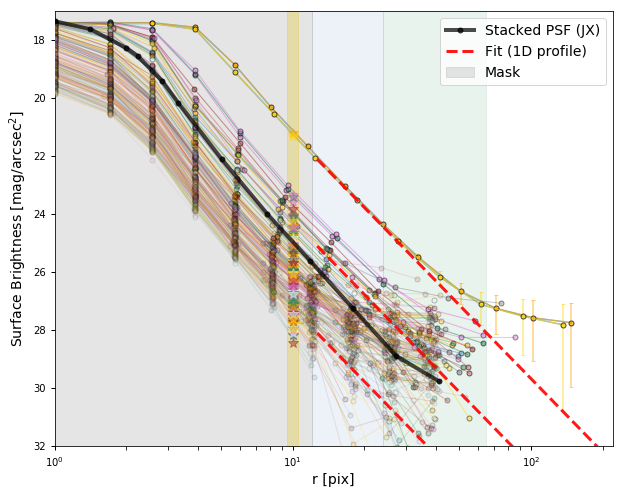

In [58]:
plot_PSF(fit_res1, res_thumb1, tab_SE_target,
         plot_stack=PSF_JX_p, mags=[14, 11, 8], ZP=ZP)

Fit results:  [-6.50495723e-01  3.37575243e+00  8.86088254e+02  2.99072081e+00]


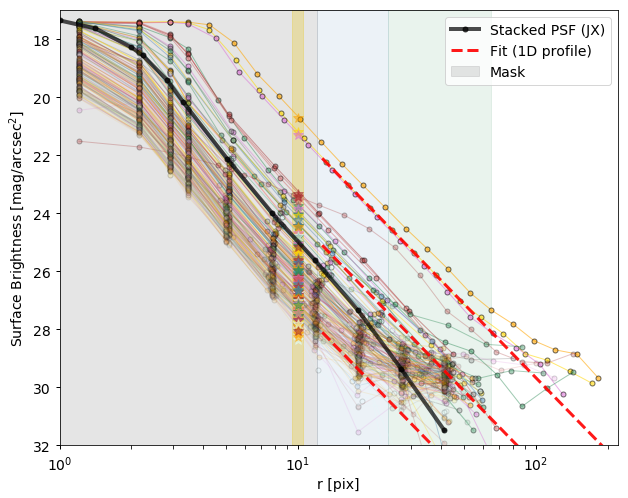

In [39]:
plot_PSF(fit_res1, res_thumb1, plot_stack=PSF_JX_p, mags=[14, 11, 8])

### G-band Patch [3100, 1400, 4100, 2400]  containing brighter stars

Read thumbs from: NGC5907-G-Thumb_15mag_X3100Y1400
Fit results:  [ -0.97171082   3.28641483 462.88711497   5.13372273]


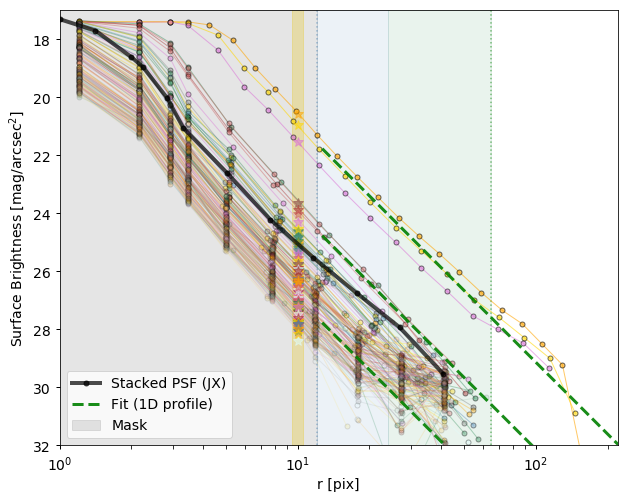

In [54]:
fit_res2 = open_nested_fitting_result(filename='NGC5907-G-fit_best_X3100Y1400.res')
fit_res2 = open_nested_fitting_result(filename='./NGC5907-G-fit_best_X3100Y1400.res')
res_thumb2 = load_thumbs('NGC5907-G-Thumb_15mag_X3100Y1400')
plot_PSF(fit_res2, res_thumb2,  plot_stack=PSF_JX, color='g', mags=[13,10,7])
plt.axvline(65, color="g", ls=":", alpha=0.5)
plt.axvline(12, color="steelblue", ls=":", alpha=0.5)